In [1]:
import numpy as np 
import pandas as pd
from tqdm import tqdm
import re
from sklearn.model_selection import train_test_split
from nltk import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.colors as mcolors
from sklearn.manifold import TSNE
import nltk

In [2]:
df=pd.read_csv('zomato.csv')

In [3]:
df.head(3)

,url,address,name,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,approx_cost(for two people),reviews_list,menu_item,listed_in(type),listed_in(city)
0,https://www.zomato.com/bangalore/jalsa-banasha...,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,4.1/5,775,080 42297555\r\n+91 9743772233,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800,"[('Rated 4.0', 'RATED\n A beautiful place to ...",[],Buffet,Banashankari
1,https://www.zomato.com/bangalore/spice-elephan...,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,Yes,No,4.1/5,787,080 41714161,Banashankari,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai",800,"[('Rated 4.0', 'RATED\n Had been here for din...",[],Buffet,Banashankari
2,https://www.zomato.com/SanchurroBangalore?cont...,"1112, Next to KIMS Medical College, 17th Cross...",San Churro Cafe,Yes,No,3.8/5,918,+91 9663487993,Banashankari,"Cafe, Casual Dining","Churros, Cannelloni, Minestrone Soup, Hot Choc...","Cafe, Mexican, Italian",800,"[('Rated 3.0', ""RATED\n Ambience is not that ...",[],Buffet,Banashankari


Combinig each rating score and review for all restraunts in the data set

Python TQDM is an iteration visualization and information library

In [4]:
value = zip(df['name'],df['reviews_list'])
name_rating=[]

In [5]:
for name,rating in tqdm(value):
    rating=eval(rating)
    for score,review in rating:
        if score:
            score=score.strip("Rated").strip()
            review=review.strip("RATED").strip()
            score=float(score)
            name_rating.append([name,score, review])
            

51717it [00:24, 2145.07it/s]


In [6]:
ratingDF=pd.DataFrame(name_rating,columns=['name','rating','review'])

In [7]:
ratingDF.head()

,name,rating,review
0,Jalsa,4.0,A beautiful place to dine in.The interiors tak...
1,Jalsa,4.0,I was here for dinner with my family on a week...
2,Jalsa,2.0,Its a restaurant near to Banashankari BDA. Me ...
3,Jalsa,4.0,We went here on a weekend and one of us had th...
4,Jalsa,5.0,The best thing about the place is itÃÃÃÃ...


Removing everything except the alphabets, numbers and spaces from the review column

In [8]:
ratingDF['review']=ratingDF['review'].apply(lambda x: re.sub('[^a-zA-Z0-9\s]',"",x))

In [9]:
ratingDF.head()

,name,rating,review
0,Jalsa,4.0,A beautiful place to dine inThe interiors take...
1,Jalsa,4.0,I was here for dinner with my family on a week...
2,Jalsa,2.0,Its a restaurant near to Banashankari BDA Me a...
3,Jalsa,4.0,We went here on a weekend and one of us had th...
4,Jalsa,5.0,The best thing about the place is its ambiance...


<b>If the rating of the data is below 2.5, it will be considered negative feedback having (poor) value 1. <br>
If the rating of the data is from [2.5,3.5] - Average and value 2 <br>
If the rating is from [3.6,5] - Good and value and positive feedback 3 </b>

In [10]:
ratingDF['rating'].value_counts()

4.0    402801
5.0    379737
3.0    180995
1.0    153622
2.0     67109
3.5     56769
4.5     51369
2.5     17900
1.5      9666
Name: rating, dtype: int64

In [11]:
ratingDF['sentiment'] = ratingDF['rating'].apply(lambda x: 1 if float(x)<=2.5 else (2 if float(x)<=3.5 else 3))

In [12]:
ratingDF.head(20)

,name,rating,review,sentiment
0,Jalsa,4.0,A beautiful place to dine inThe interiors take...,3
1,Jalsa,4.0,I was here for dinner with my family on a week...,3
2,Jalsa,2.0,Its a restaurant near to Banashankari BDA Me a...,1
3,Jalsa,4.0,We went here on a weekend and one of us had th...,3
4,Jalsa,5.0,The best thing about the place is its ambiance...,3
5,Jalsa,5.0,Great food and pleasant ambience Expensive but...,3
6,Jalsa,4.0,Good ambience with tasty food\nCheese chilli p...,3
7,Jalsa,4.0,You cant go wrong with Jalsa Never been a fan ...,3
8,Jalsa,5.0,Overdelighted by the service and food provided...,3
9,Jalsa,4.0,The place is nice and comfortable Food wise al...,3


In [13]:
ratingDF['sentiment'].value_counts()

3    833907
1    248297
2    237764
Name: sentiment, dtype: int64

### Sentiment Analysis Using VADER

In [14]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [17]:
analyzer = SentimentIntensityAnalyzer()

In [18]:
import time
def sentiment_analysis_scores(line):
    score = analyzer.polarity_scores(line)
    return (score['compound'], score['pos'], score['neu'], score['neg'])
start = time.time()
VADERSCORES = ratingDF['review'].apply(sentiment_analysis_scores)
end = time.time()   
print("Total Time(s) taken using VADER : ", end-start)

Total Time(s) taken using VADER :  853.6700959205627


In [19]:
VDF = pd.DataFrame(list(VADERSCORES.values),
                  columns=['VADER Score (Compound)',
                            'VADER Score (Positive)',
                            'VADER Score (Neutral)',
                            'VADER Score (Negative)'])
ratingDF_vader = pd.concat([ratingDF, VDF],axis=1)


In [20]:
ratingDF_vader.head(10)

,name,rating,review,sentiment,VADER Score (Compound),VADER Score (Positive),VADER Score (Neutral),VADER Score (Negative)
0,Jalsa,4.0,A beautiful place to dine inThe interiors take...,3,0.7430,0.139,0.799,0.062
1,Jalsa,4.0,I was here for dinner with my family on a week...,3,0.9623,0.289,0.684,0.027
2,Jalsa,2.0,Its a restaurant near to Banashankari BDA Me a...,1,0.7964,0.172,0.781,0.047
3,Jalsa,4.0,We went here on a weekend and one of us had th...,3,0.9678,0.275,0.725,0.000
4,Jalsa,5.0,The best thing about the place is its ambiance...,3,0.9702,0.395,0.605,0.000
5,Jalsa,5.0,Great food and pleasant ambience Expensive but...,3,0.9604,0.423,0.577,0.000
6,Jalsa,4.0,Good ambience with tasty food\nCheese chilli p...,3,0.8291,0.192,0.808,0.000
7,Jalsa,4.0,You cant go wrong with Jalsa Never been a fan ...,3,0.3911,0.116,0.843,0.042
8,Jalsa,5.0,Overdelighted by the service and food provided...,3,0.8399,0.184,0.816,0.000
9,Jalsa,4.0,The place is nice and comfortable Food wise al...,3,0.9124,0.215,0.754,0.031


### Sentiment Analysis Using TextBlob

In [21]:
from textblob import TextBlob

In [22]:
start = time.time()
TEXTBLOBSCORES = ratingDF['review'].apply(lambda x: TextBlob(x).sentiment.polarity)
end = time.time()
TDF = pd.DataFrame(list(TEXTBLOBSCORES.values),
                  columns=['TEXTBLOB SCORE (Polarity)'])
ratingDF_TextBlob = pd.concat([ratingDF, TDF], axis = 1)
print("Total Time(s) taken using TEXTBLOB : ", end-start)

Total Time(s) taken using TEXTBLOB :  561.6311359405518


In [23]:
ratingDF_TextBlob.head(10)

,name,rating,review,sentiment,TEXTBLOB SCORE (Polarity)
0,Jalsa,4.0,A beautiful place to dine inThe interiors take...,3,0.172321
1,Jalsa,4.0,I was here for dinner with my family on a week...,3,0.500000
2,Jalsa,2.0,Its a restaurant near to Banashankari BDA Me a...,1,0.112500
3,Jalsa,4.0,We went here on a weekend and one of us had th...,3,0.641667
4,Jalsa,5.0,The best thing about the place is its ambiance...,3,0.485000
5,Jalsa,5.0,Great food and pleasant ambience Expensive but...,3,0.386389
6,Jalsa,4.0,Good ambience with tasty food\nCheese chilli p...,3,0.266667
7,Jalsa,4.0,You cant go wrong with Jalsa Never been a fan ...,3,-0.100000
8,Jalsa,5.0,Overdelighted by the service and food provided...,3,0.311111
9,Jalsa,4.0,The place is nice and comfortable Food wise al...,3,0.282857


In [24]:
ratingDF_vader.head(10)

,name,rating,review,sentiment,VADER Score (Compound),VADER Score (Positive),VADER Score (Neutral),VADER Score (Negative)
0,Jalsa,4.0,A beautiful place to dine inThe interiors take...,3,0.7430,0.139,0.799,0.062
1,Jalsa,4.0,I was here for dinner with my family on a week...,3,0.9623,0.289,0.684,0.027
2,Jalsa,2.0,Its a restaurant near to Banashankari BDA Me a...,1,0.7964,0.172,0.781,0.047
3,Jalsa,4.0,We went here on a weekend and one of us had th...,3,0.9678,0.275,0.725,0.000
4,Jalsa,5.0,The best thing about the place is its ambiance...,3,0.9702,0.395,0.605,0.000
5,Jalsa,5.0,Great food and pleasant ambience Expensive but...,3,0.9604,0.423,0.577,0.000
6,Jalsa,4.0,Good ambience with tasty food\nCheese chilli p...,3,0.8291,0.192,0.808,0.000
7,Jalsa,4.0,You cant go wrong with Jalsa Never been a fan ...,3,0.3911,0.116,0.843,0.042
8,Jalsa,5.0,Overdelighted by the service and food provided...,3,0.8399,0.184,0.816,0.000
9,Jalsa,4.0,The place is nice and comfortable Food wise al...,3,0.9124,0.215,0.754,0.031


### Associating Vader Score with a Sentiment

In [25]:
def sentiment(score,threshold): #threshold according to VADER documentation = 0.05 #score is compound score
    if(score>=threshold):
        return 3
    elif(score>-threshold and score<threshold):
        return 2
    elif(score<=threshold):
        return 1

In [26]:
VADER_sent = ratingDF_vader['VADER Score (Compound)'].apply(lambda x : sentiment(x,0.1))

In [27]:
VS = pd.DataFrame(list(VADER_sent.values),
                  columns=['Sentiment_Final'])

In [28]:
VS.head()

,Sentiment_Final
0,3
1,3
2,3
3,3
4,3


In [29]:
ratingDF_vader = pd.concat([ratingDF_vader,VS],axis = 1)

In [30]:
ratingDF_vader.head()

,name,rating,review,sentiment,VADER Score (Compound),VADER Score (Positive),VADER Score (Neutral),VADER Score (Negative),Sentiment_Final
0,Jalsa,4.0,A beautiful place to dine inThe interiors take...,3,0.7430,0.139,0.799,0.062,3
1,Jalsa,4.0,I was here for dinner with my family on a week...,3,0.9623,0.289,0.684,0.027,3
2,Jalsa,2.0,Its a restaurant near to Banashankari BDA Me a...,1,0.7964,0.172,0.781,0.047,3
3,Jalsa,4.0,We went here on a weekend and one of us had th...,3,0.9678,0.275,0.725,0.000,3
4,Jalsa,5.0,The best thing about the place is its ambiance...,3,0.9702,0.395,0.605,0.000,3


In [31]:
VS['Sentiment_Final'].value_counts()

3    1050685
1     184639
2      84644
Name: Sentiment_Final, dtype: int64

In [32]:
ratingDF_vader['sentiment'].value_counts()


3    833907
1    248297
2    237764
Name: sentiment, dtype: int64

### Performance Evaluation of VADER

In [33]:
original = dict(ratingDF_vader['sentiment'].value_counts())
model = dict(VS['Sentiment_Final'].value_counts())

In [34]:
print(original)
print(model)

{3: 833907, 1: 248297, 2: 237764}
{3: 1050685, 1: 184639, 2: 84644}


In [37]:
print("Positive Reviews Accuracy : {}%".format(100-(abs(original[3]-model[3]))*100/(original[3])))
print("Negative Reviews Accuracy : {}%".format(100-(abs(original[1]-model[2]))*100/(original[1])))
print("Neutral Reviews Accuracy : {}%".format(100-(abs(original[2]-model[1]))*100/(original[2])))

Positive Reviews Accuracy : 74.00453527791468%
Negative Reviews Accuracy : 34.089819852837536%
Neutral Reviews Accuracy : 77.65641560539022%


### Assigning TextBlob Score with a Sentiment 

In [38]:
ratingDF_TextBlob.head(10)


,name,rating,review,sentiment,TEXTBLOB SCORE (Polarity)
0,Jalsa,4.0,A beautiful place to dine inThe interiors take...,3,0.172321
1,Jalsa,4.0,I was here for dinner with my family on a week...,3,0.500000
2,Jalsa,2.0,Its a restaurant near to Banashankari BDA Me a...,1,0.112500
3,Jalsa,4.0,We went here on a weekend and one of us had th...,3,0.641667
4,Jalsa,5.0,The best thing about the place is its ambiance...,3,0.485000
5,Jalsa,5.0,Great food and pleasant ambience Expensive but...,3,0.386389
6,Jalsa,4.0,Good ambience with tasty food\nCheese chilli p...,3,0.266667
7,Jalsa,4.0,You cant go wrong with Jalsa Never been a fan ...,3,-0.100000
8,Jalsa,5.0,Overdelighted by the service and food provided...,3,0.311111
9,Jalsa,4.0,The place is nice and comfortable Food wise al...,3,0.282857


In [39]:
def Sentimentblob(score,threshold):
    if(score>=threshold):
        return 3
    elif(score>-threshold and score<threshold):
        return 2
    elif(score<=-threshold):
        return 1

In [40]:
TextBlob_sent = ratingDF_TextBlob['TEXTBLOB SCORE (Polarity)'].apply(lambda x : Sentimentblob(x,0.1))

In [41]:
BS = pd.DataFrame(list(TextBlob_sent.values),
                  columns=['Sentiment_Final Blob'])


In [42]:
ratingDF_TextBlob = pd.concat([ratingDF_TextBlob,BS], axis=1)

In [43]:
ratingDF_TextBlob.head()

,name,rating,review,sentiment,TEXTBLOB SCORE (Polarity),Sentiment_Final Blob
0,Jalsa,4.0,A beautiful place to dine inThe interiors take...,3,0.172321,3
1,Jalsa,4.0,I was here for dinner with my family on a week...,3,0.500000,3
2,Jalsa,2.0,Its a restaurant near to Banashankari BDA Me a...,1,0.112500,3
3,Jalsa,4.0,We went here on a weekend and one of us had th...,3,0.641667,3
4,Jalsa,5.0,The best thing about the place is its ambiance...,3,0.485000,3


In [44]:
ratingDF_TextBlob['sentiment'].value_counts()

3    833907
1    248297
2    237764
Name: sentiment, dtype: int64

In [45]:
ratingDF_TextBlob['Sentiment_Final Blob']

0          3
1          3
2          3
3          3
4          3
          ..
1319963    3
1319964    3
1319965    3
1319966    3
1319967    3
Name: Sentiment_Final Blob, Length: 1319968, dtype: int64

### Performance Evaluation of TEXTBLOB

In [46]:
original = dict(ratingDF_TextBlob['sentiment'].value_counts())
model = dict(ratingDF_TextBlob['Sentiment_Final Blob'].value_counts())
print(original)
print(model)

{3: 833907, 1: 248297, 2: 237764}
{3: 960141, 2: 204381, 1: 155446}


In [47]:
print("Positive Reviews Accuracy : {}%".format(100-(abs(original[3]-model[3]))*100/(original[3])))
print("Negative Reviews Accuracy : {}%".format(100-(abs(original[1]-model[2]))*100/(original[1])))
print("Neutral Reviews Accuracy : {}%".format(100-(abs(original[2]-model[1]))*100/(original[2])))

Positive Reviews Accuracy : 84.86234076461764%
Negative Reviews Accuracy : 82.31311695268167%
Neutral Reviews Accuracy : 65.37827425514377%


<b>The performnace using wither TextBlob or VADER sentiment library depends heavily on the hyperparameter 'threshold',<br>
Which is a user defined boundary to classify a review as either positve, negative or neutral.<br></b>

<b>It is observed that generalization of one the category, though significantly improves <br>
its classifying accuracy but negatively impacts atleast one other sentiment category.</b>

In [65]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [51]:
# Evaluating for VADER

ratingDF_vader.head()



,name,rating,review,sentiment,VADER Score (Compound),VADER Score (Positive),VADER Score (Neutral),VADER Score (Negative),Sentiment_Final
0,Jalsa,4.0,A beautiful place to dine inThe interiors take...,3,0.7430,0.139,0.799,0.062,3
1,Jalsa,4.0,I was here for dinner with my family on a week...,3,0.9623,0.289,0.684,0.027,3
2,Jalsa,2.0,Its a restaurant near to Banashankari BDA Me a...,1,0.7964,0.172,0.781,0.047,3
3,Jalsa,4.0,We went here on a weekend and one of us had th...,3,0.9678,0.275,0.725,0.000,3
4,Jalsa,5.0,The best thing about the place is its ambiance...,3,0.9702,0.395,0.605,0.000,3


In [63]:
y_true = list(ratingDF_vader['sentiment'])
y_pred = list(ratingDF_vader['Sentiment_Final'])
cm = confusion_matrix(y_true,y_pred)



Text(69.0, 0.5, 'Truth')

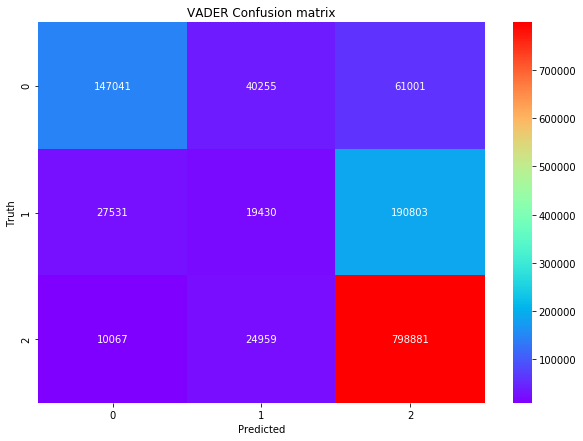

In [84]:
plt.figure(figsize=(10,7))
sns.heatmap(cm,annot=True,cmap='rainbow',fmt='g')
plt.title("VADER Confusion matrix")
plt.xlabel("Predicted")
plt.ylabel("Truth")

In [79]:
precision0 = (cm[0][0])/(cm[0][0]+cm[1][0]+cm[2][0])
recall0 = (cm[0][0])/(cm[0][0]+cm[0][1]+cm[0][2]) #aka TRP
fscore0 = 2*(precision0*recall0)/(precision0+recall0)


In [80]:
print("Scores for Negative Reviews Classified")

print("Precision: ",precision0)
print("Recall or TPR: ",recall0)
print("F Score: ",fscore0)


Scores for Negative Reviews Classified
Precision:  0.7963702143100861
Recall or TPR:  0.5921980531379759
F Score:  0.67927361088013


In [81]:
precision1 = (cm[1][1])/(cm[1][1]+cm[0][1]+cm[2][1])
recall1 = (cm[1][1])/(cm[1][1]+cm[1][0]+cm[1][2]) #aka TRP
fscore1 = 2*(precision1*recall1)/(precision1+recall1)

print("Scores for Neutral Reviews Classified")

print("Precision: ",precision1)
print("Recall or TPR: ",recall1)
print("F Score: ",fscore1)


Scores for Neutral Reviews Classified
Precision:  0.22954964321156845
Recall or TPR:  0.08171968843054457
F Score:  0.12053050792784298


In [83]:
precision2 = (cm[2][2])/(cm[2][2]+cm[0][2]+cm[1][2])
recall2 = (cm[2][2])/(cm[2][2]+cm[2][0]+cm[2][1]) #aka TRP
fscore2 = 2*(precision2*recall2)/(precision2+recall2)

print("Scores for Postive Reviews Classified")

print("Precision: ",precision2)
print("Recall or TPR: ",recall2)
print("F Score: ",fscore2)

Scores for Postive Reviews Classified
Precision:  0.7603430143192298
Recall or TPR:  0.9579977143734253
F Score:  0.8478026013057468


In [85]:
y_true = list(ratingDF_TextBlob['sentiment'])
y_pred = list(ratingDF_TextBlob['Sentiment_Final Blob'])
cm = confusion_matrix(y_true,y_pred)

In [86]:
cm

array([[125591,  76703,  46003],
       [ 18420,  53791, 165553],
       [ 11435,  73887, 748585]], dtype=int64)

Text(69.0, 0.5, 'Truth')

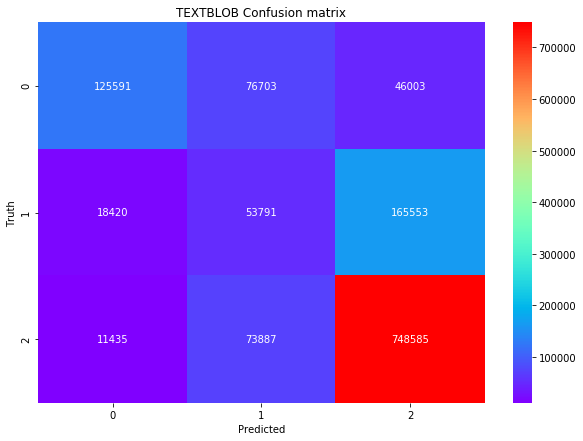

In [87]:
plt.figure(figsize=(10,7))
sns.heatmap(cm,annot=True,cmap='rainbow',fmt='g')
plt.title("TEXTBLOB Confusion matrix")
plt.xlabel("Predicted")
plt.ylabel("Truth")

In [88]:
precision0 = (cm[0][0])/(cm[0][0]+cm[1][0]+cm[2][0])
recall0 = (cm[0][0])/(cm[0][0]+cm[0][1]+cm[0][2]) #aka TRP
fscore0 = 2*(precision0*recall0)/(precision0+recall0)

print("Scores for Negative Reviews Classified")

print("Precision: ",precision0)
print("Recall or TPR: ",recall0)
print("F Score: ",fscore0)


Scores for Negative Reviews Classified
Precision:  0.8079397346988665
Recall or TPR:  0.505809574823699
F Score:  0.6221333868327129


In [89]:
precision1 = (cm[1][1])/(cm[1][1]+cm[0][1]+cm[2][1])
recall1 = (cm[1][1])/(cm[1][1]+cm[1][0]+cm[1][2]) #aka TRP
fscore1 = 2*(precision1*recall1)/(precision1+recall1)

print("Scores for Neutral Reviews Classified")

print("Precision: ",precision1)
print("Recall or TPR: ",recall1)
print("F Score: ",fscore1)


Scores for Neutral Reviews Classified
Precision:  0.263189826843004
Recall or TPR:  0.2262369408320856
F Score:  0.24331836840855375


In [90]:
precision2 = (cm[2][2])/(cm[2][2]+cm[0][2]+cm[1][2])
recall2 = (cm[2][2])/(cm[2][2]+cm[2][0]+cm[2][1]) #aka TRP
fscore2 = 2*(precision2*recall2)/(precision2+recall2)

print("Scores for Postive Reviews Classified")

print("Precision: ",precision2)
print("Recall or TPR: ",recall2)
print("F Score: ",fscore2)

Scores for Postive Reviews Classified
Precision:  0.7796615288796125
Recall or TPR:  0.8976840343107805
F Score:  0.8345205925371005
